# 주거 데이터 다운로드 보고

**작성자** : 권휘준
**작성일** : 2024.04.24

## 1. 아파트 실거래 다운로드

- 개발계정 신청을 통해 2006년부터 2024년 4월 19일 데이터까지 다운로드 했습니다
- 총 데이터의 수는 971만여개입니다.

In [1]:
from sqlalchemy import create_engine
from sqlalchemy.sql import text
eng = create_engine("sqlite:///data_load/real_estate.db")

query = f"SELECT COUNT(*) FROM apt_distinct_coded_temp"
with eng.connect() as conn:
    result = conn.execute(text(query))
    for row in result:
        print(f'2006년 ~ 2024년 총 매매 수 : {row[0]}')


2006년 ~ 2024년 총 매매 수 : 9712311


In [2]:
eng = create_engine("sqlite:///data_load/real_estate.db")
trade = {}
for year in range(2006, 2025):
    query = f"SELECT COUNT(*) FROM apt_distinct_coded_temp WHERE 년 = {year}"
    with eng.connect() as conn:
        result = conn.execute(text(query))
        count = result.scalar()
        trade[year] = count

### 연도별 아파트 거래수

In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  #

Text(0.5, 1.0, '연도별 아파트 매매 실거래수 (2006 ~ 2024)')

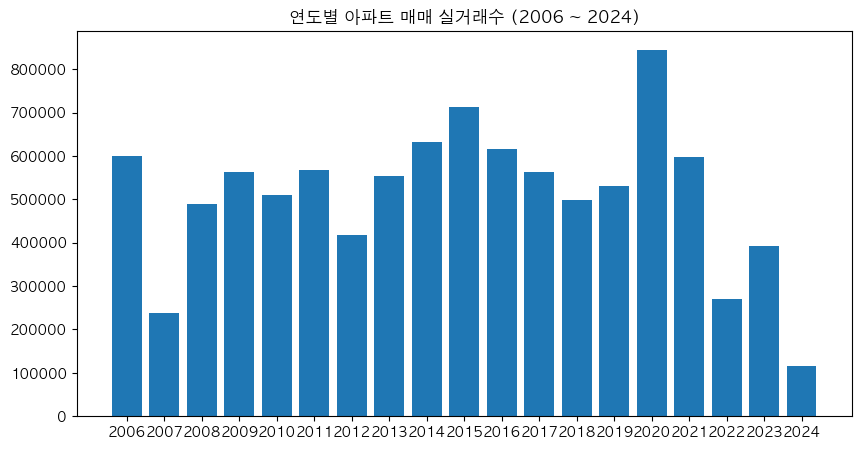

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 5))
years = list(trade.keys())
trans = list(trade.values())
plt.bar(list(trade.keys()), list(trade.values()))
plt.xticks(years)
plt.title("연도별 아파트 매매 실거래수 (2006 ~ 2024)")

## 2. 법정동 행정동 변환

- 법정동코드를 현재시점 행정동코드로 변환했습니다.
- https://github.com/WooilJeong/PublicDataReader에서 제공하는 라이브러리를 활용했습니다.
- 법정동 코드는 3641개, 행정동 코드의 수는 1950개입니다.

In [4]:
query = "SELECT COUNT(DISTINCT 법정동코드) FROM apt_distinct_coded_temp"
with eng.connect() as conn:
    result = conn.execute(text(query))
    for row in result:
        print(f"법정동 코드의 수 :{row[0]}")

법정동 코드의 수 :3641


In [22]:
query = "SELECT COUNT(DISTINCT 행정동코드) FROM apt_distinct_coded_temp"
with eng.connect() as conn:
    result = conn.execute(text(query))
    for row in result:
        print(f"행정동 코드의 수 :{row[0]}")

행정동 코드의 수 :1950


### 예시 : 성북구 행정동별 평균 거래금액 

In [41]:
query = '''
    SELECT 행정동코드, AVG(CAST(REPLACE(거래금액, ",", "") AS INTEGER)) AS avg_price
    FROM apt_distinct_coded_temp
    WHERE 행정동코드 LIKE '11290%' AND 년 = 2023
    GROUP BY 행정동코드
    ;
'''

avg_test = {}
with eng.connect() as conn:
    result = conn.execute(text(query))
    for row in result:
        행정동코드 = str(row[0])
        평균거래금액 = int(row[1])
        avg_test[행정동코드] = 평균거래금액
        

Text(0, 0.5, '행정동코드')

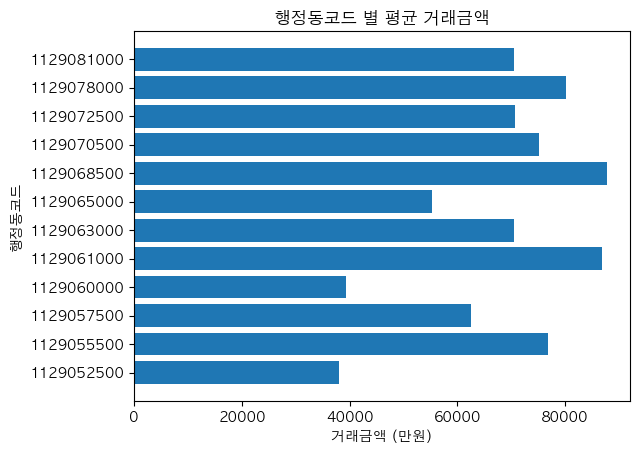

In [47]:
x = list(avg_test.keys())
y = list(avg_test.values())
plt.barh(x, y)
plt.title("성북구 행정동 별 평균 거래금액 (2023년)")
plt.xlabel("거래금액 (만원)")
plt.ylabel("행정동코드")

### 문제점

-  법정동코드와 행정동코드가 일대다 매칭이 되는 경우가 있습니다.
- 예를들어 전라남도 목포시 산정동(법정동 : 4611010200)에는 10개가 넘는 행정동이 존재합니다.
- 법정동코드 정보만으로는 정확한 행정동코드 재현에는 어려움이 있을 것 같습니다.
- 도로명건물본번호코드, 도로명건물부번호코드, 도로명시군구코드등을 활용하는 방안을 고려할 수 있습니다.

In [52]:
import PublicDataReader as pdr
conn_code= pdr.code_hdong_bdong()
mokpo = conn_code[conn_code["법정동코드"] == "4611010200"]
mokpo_now = mokpo[mokpo["말소일자"] == ""]
mokpo_now[["시도명", "시군구명", "읍면동명", "동리명", "법정동코드", "행정동코드"]]

출처: 행정기관(행정동) 및 관할구역(법정동) 변경내역(2024.2.1. 시행)


,시도명,시군구명,읍면동명,동리명,법정동코드,행정동코드
30346,전라남도,목포시,용당1동,산정동,4611010200,4611051000
30352,전라남도,목포시,연동,산정동,4611010200,4611053500
30357,전라남도,목포시,산정동,산정동,4611010200,4611054500
30362,전라남도,목포시,연산동,산정동,4611010200,4611055400
30364,전라남도,목포시,원산동,산정동,4611010200,4611055800
30368,전라남도,목포시,대성동,산정동,4611010200,4611056500
30380,전라남도,목포시,목원동,산정동,4611010200,4611059500
30413,전라남도,목포시,동명동,산정동,4611010200,4611064000
30419,전라남도,목포시,삼학동,산정동,4611010200,4611064500
30436,전라남도,목포시,만호동,산정동,4611010200,4611065500


## 남은 작업
1. 이번주 및 다음주에는 거래시점 기준 행정동코드 매칭 작업을 하도록 하겠습니다.  